# Intro

I'm trying to learn the very basics with this exercise. My goal is to train a linear regression model with a subset of columns from this interesting dataset in order to predict the value of a used car.

Any help or advice is welcome!!!

### Changelist

* added name length feature

* better study on the data
* used seaborn to plot
* added random forest and xgboost algorithms

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib
import seaborn as sns


### Useful functions

In [5]:
def category_values(dataframe, categories):
    for c in categories:
        print('\n', dataframe.groupby(by=c)[c].count().sort_values(ascending=False))
        print('Nulls: ', dataframe[c].isnull().sum())

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )



# Preparing data

## Reading from file

Just reading the file and printing some lines.

In [6]:
# df = pd.read_csv('../input/autos.csv', sep=',', header=0, encoding='cp1252')
df = pd.read_csv('autos.csv.gz', sep=',', header=0, compression='gzip',encoding='cp1252')
df.sample(10)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
263272,2016-03-24 16:50:17,Volkswagen_Golf_2.0_GTI_DSG/Bi_Xenon/DYNAUDIO/...,privat,Angebot,18200,control,limousine,2010,automatik,211,golf,50000,7,benzin,volkswagen,nein,2016-03-24 00:00:00,0,76332,2016-04-01 12:47:18
306651,2016-03-05 16:06:23,Vw_polo_6N2_TÜV_1.2017,privat,Angebot,1550,control,NaN,2017,manuell,54,polo,150000,5,benzin,volkswagen,nein,2016-03-05 00:00:00,0,63263,2016-04-07 13:16:11
253940,2016-03-31 23:43:28,Opel_Corsa_1.2_16V,privat,Angebot,1299,control,kleinwagen,2001,manuell,75,corsa,150000,11,benzin,opel,nein,2016-03-31 00:00:00,0,89168,2016-04-06 19:45:50
330174,2016-03-10 10:57:27,VW_Caddy_14d,privat,Angebot,1250,test,andere,1989,manuell,75,caddy,150000,12,benzin,volkswagen,nein,2016-03-10 00:00:00,0,52525,2016-03-16 07:19:00
187966,2016-03-14 08:54:26,M6_Sport_2.0_Exclusiv,privat,Angebot,9500,test,limousine,2004,manuell,147,6_reihe,90000,4,benzin,mazda,NaN,2016-03-14 00:00:00,0,49084,2016-04-07 08:45:28
229077,2016-04-01 10:48:42,Audi_A4_1_9_TDi_110_PS_mit_Vollausstattung,privat,Angebot,2500,control,kombi,1996,manuell,110,a4,150000,12,diesel,audi,nein,2016-04-01 00:00:00,0,83022,2016-04-07 07:17:11
222519,2016-03-09 21:52:25,Renault_fast_zu_verschenken_fuer_4_Kisten_Deit...,privat,Angebot,70,test,coupe,1994,manuell,90,laguna,150000,5,benzin,renault,NaN,2016-03-09 00:00:00,0,26129,2016-03-14 18:44:45
290357,2016-03-25 16:44:18,Ford_Galaxy_Scheckheft,privat,Angebot,3950,control,bus,2003,manuell,110,galaxy,150000,9,diesel,ford,nein,2016-03-25 00:00:00,0,24161,2016-03-27 03:47:11
246105,2016-03-05 14:07:08,Opel_Corsa_B_1_2_L_TÜV_01.2018,privat,Angebot,750,test,NaN,2018,manuell,0,corsa,150000,4,benzin,opel,nein,2016-03-05 00:00:00,0,53547,2016-03-06 12:33:37
21761,2016-03-19 20:47:00,BMW_635,privat,Angebot,11900,control,coupe,1979,manuell,218,6er,150000,3,benzin,bmw,nein,2016-03-19 00:00:00,0,13599,2016-04-07 08:46:26


Let's see some info from numeric fields

In [7]:
df.describe()


,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


## Dropping some useless columns

Some column can already be dropped.

In [8]:
print(df.seller.unique())
print(df.offerType.unique())
print(df.abtest.unique())
print(df.nrOfPictures.unique())

['privat' 'gewerblich']
['Angebot' 'Gesuch']
['test' 'control']
[0]


Seller has only one value, while offerType and abtest has no relevance for the analysis. So far, I still don't know how to use the dateCrawled column.

Therefore I modify the dataframe droppint all those features.

In [9]:
df.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures'], axis='columns', inplace=True)


## Cleaning data

Cleaning data from duplicates, NaNs and selecting reasonable ranges for columns


In [10]:
print("Too new: %d" % df.loc[df.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % df.loc[df.yearOfRegistration < 1950].count()['name'])
print("Too cheap: %d" % df.loc[df.price < 100].count()['name'])
print("Too expensive: " , df.loc[df.price > 150000].count()['name'])
print("Too few km: " , df.loc[df.kilometer < 5000].count()['name'])
print("Too many km: " , df.loc[df.kilometer > 200000].count()['name'])
print("Too few PS: " , df.loc[df.powerPS < 10].count()['name'])
print("Too many PS: " , df.loc[df.powerPS > 500].count()['name'])
print("Fuel types: " , df['fuelType'].unique())
#print("Offer types: " , df['offerType'].unique())
#print("Sellers: " , df['seller'].unique())
print("Damages: " , df['notRepairedDamage'].unique())
#print("Pics: " , df['nrOfPictures'].unique()) # nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) )
print("Postale codes: " , df['postalCode'].unique())
print("Vehicle types: " , df['vehicleType'].unique())
print("Brands: " , df['brand'].unique())

# Cleaning data
#valid_models = df.dropna()

#### Removing the duplicates
dedups = df.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage','postalCode'])

#### Removing the outliers
no_outliers = dedups[
        (dedups.yearOfRegistration <= 2016) 
      & (dedups.yearOfRegistration >= 1950) 
      & (dedups.price >= 100) 
      & (dedups.price <= 150000) 
      & (dedups.powerPS >= 10) 
      & (dedups.powerPS <= 500)]

print("-----------------\nData kept for analisys: %d percent of the entire set\n-----------------" % (100 * no_outliers['name'].count() / df['name'].count()))


Too new: 14680
Too old: 289
Too cheap: 13320
Too expensive:  232
Too few km:  0
Too many km:  0
Too few PS:  41040
Too many PS:  835
Fuel types:  ['benzin' 'diesel' nan 'lpg' 'andere' 'hybrid' 'cng' 'elektro']
Damages:  [nan 'ja' 'nein']
Postale codes:  [70435 66954 90480 ..., 38528 38325 31096]
Vehicle types:  [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
Brands:  ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda' 'nissan'
 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat' 'mini'
 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'porsche' 'toyota' 'chevrolet'
 'dacia' 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'rover'
 'land_rover' 'lada']
-----------------
Data kept for analisys: 82 percent of the entire set
-----------------


## Working on the `null` values

Checking if theree are NaNs to fix or drop

In [11]:
dedups.isnull().sum()

name                       0
price                      0
vehicleType            37422
yearOfRegistration         0
gearbox                19803
powerPS                    0
model                  20288
kilometer                  0
monthOfRegistration        0
fuelType               33081
brand                      0
notRepairedDamage      70770
dateCreated                0
postalCode                 0
lastSeen                   0
dtype: int64

Some decisions to take for the nulls in the following fields: vehicleType (37422 nulls), gearbox (19803 nulls), model (20288 nulls), fuelType (33081 nulls), notRepairedDamage (70770 nulls).

### `model`-`brand`-`vehicleType`
If we have the `model` we could determine the `brand` and the `vehicleType` calculating the mode for the corresponding fields in the rest of the dataset. The opposite combinations are not true. So I think the actions should be:

| `vehicleType` | `brand` | `model` | Action 
| ---           | ---     | ---     |
| `null`        |  `null` | [value] | Set the other fields
| `null`        | [value] | `null`  | Delete
| [value]       |  `null` | `null`  | Delete

__So far, I'll drop all the NaNs in these 3 fields.__

### `notRepairedDamage`
Those with null `notRepairedDamage` field could be set to "`not-declared`" value for example.

### `fuelType`
Null `fuelType`s could be set to "`not-declared`" value again.

### `gearbox`
Null `fuelType`s could be set to "`not-declared`" value again.



In [12]:
dedups['notRepairedDamage'].fillna(value='not-declared', inplace=True)
dedups['fuelType'].fillna(value='not-declared', inplace=True)
dedups['gearbox'].fillna(value='not-declared', inplace=True)
dedups['vehicleType'].fillna(value='not-declared', inplace=True)
dedups['model'].fillna(value='not-declared', inplace=True)

/opt/conda/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Checking if all the nulls have been filled or dropped.

In [13]:
dedups.isnull().sum()

name                   0
price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
postalCode             0
lastSeen               0
dtype: int64

OK, we're clear. Let's do some visualization now.

## Visualizations
### Categories distribution
Let's see some charts to understand how data is distributed across the categories

gearbox
manuell         269733
automatik        75361
not-declared     19803
Name: gearbox, dtype: int64


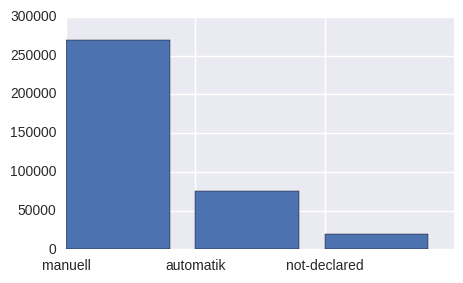

model
golf            29539
andere          26076
not-declared    20288
3er             20286
polo            12930
Name: model, dtype: int64


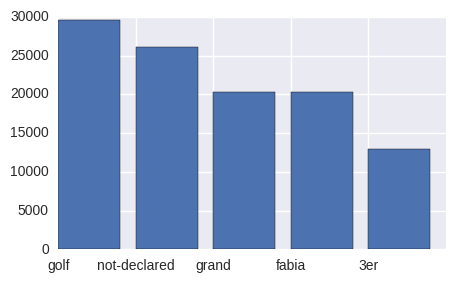

brand
volkswagen       78226
bmw              39565
opel             39359
mercedes_benz    34680
audi             32144
Name: brand, dtype: int64


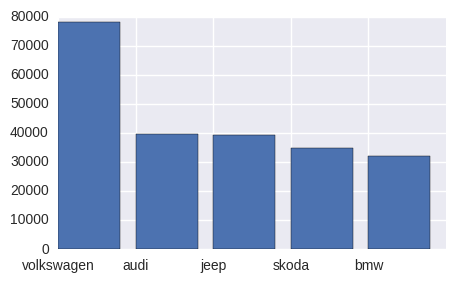

vehicleType
limousine       94035
kleinwagen      78621
kombi           66262
not-declared    37422
bus             29641
Name: vehicleType, dtype: int64


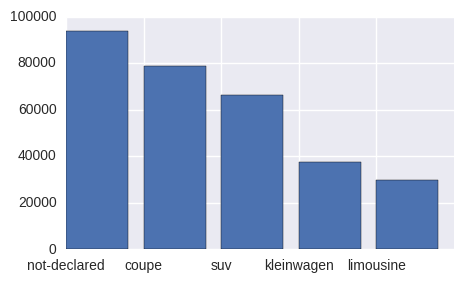

fuelType
benzin          220296
diesel          105087
not-declared     33081
lpg               5287
cng                561
Name: fuelType, dtype: int64


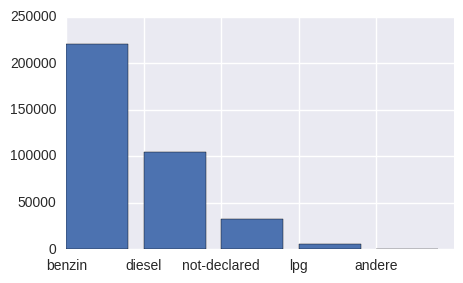

notRepairedDamage
nein            258290
not-declared     70770
ja               35837
Name: notRepairedDamage, dtype: int64


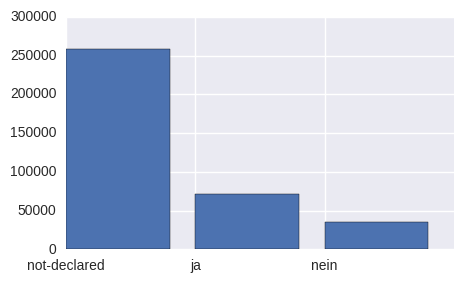

In [14]:
categories = ['gearbox', 'model', 'brand', 'vehicleType', 'fuelType', 'notRepairedDamage']

for i, c in enumerate(categories):
    v = dedups[c].unique()
    
    g = dedups.groupby(by=c)[c].count().sort_values(ascending=False)
    r = range(min(len(v), 5))

    print( g.head())
    plt.figure(figsize=(5,3))
    plt.bar(r, g.head()) 
    plt.xticks(r, v)
    plt.show()

### Correlations
Let's see how features are correlated each other and, more important, with the price.

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
price,1.000000,-0.000184,0.006853,-0.000631,-0.002853,-0.003210
yearOfRegistration,-0.000184,1.000000,0.000462,-0.055116,-0.011513,-0.001380
powerPS,0.006853,0.000462,1.000000,-0.009507,0.043455,0.028021
kilometer,-0.000631,-0.055116,-0.009507,1.000000,0.003830,-0.030133
monthOfRegistration,-0.002853,-0.011513,0.043455,0.003830,1.000000,0.016120
postalCode,-0.003210,-0.001380,0.028021,-0.030133,0.016120,1.000000


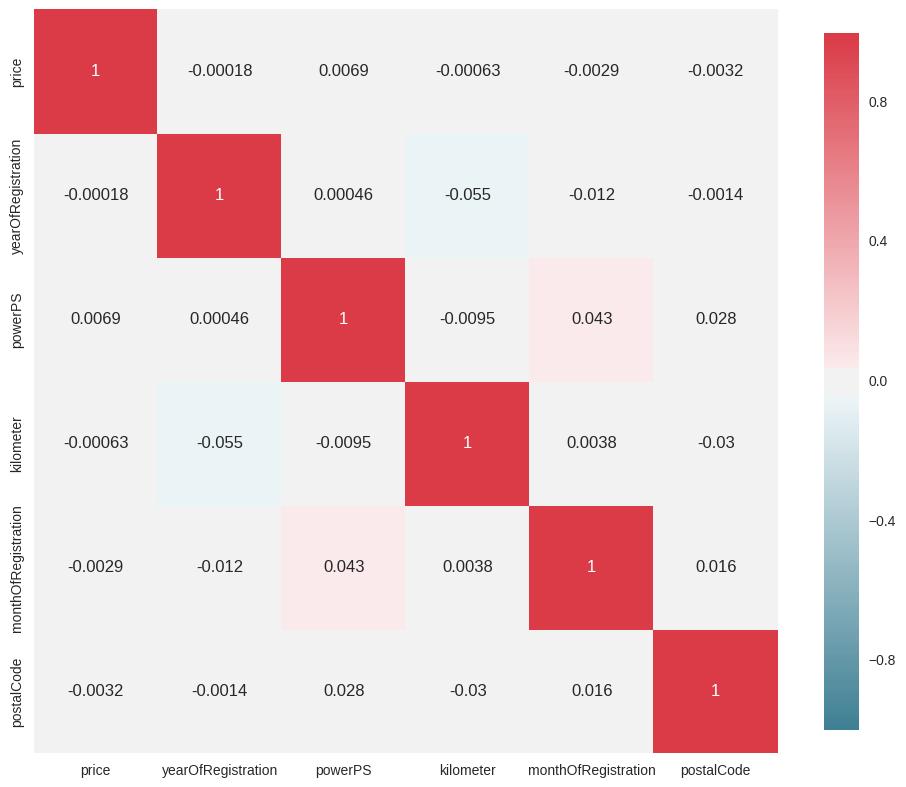

In [16]:
features = ['yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']
target = 'price'

plot_correlation_map(dedups)
dedups.corr()

In [20]:
le = preprocessing.LabelEncoder()

dedups = dedups.apply(le.fit_transform)

,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
name,1.000000,-0.114067,-0.094856,-0.013593,0.102117,-0.218017,0.432508,-0.019750,-0.017331,-0.010082,0.810802,0.005685,0.000362,-0.061905,-0.012063
price,-0.114067,1.000000,-0.060637,0.380492,-0.331638,0.551549,-0.035733,-0.373654,0.120536,-0.004354,-0.122732,-0.050802,0.016219,0.094534,0.178837
vehicleType,-0.094856,-0.060637,1.000000,0.139659,-0.004052,0.008022,-0.105496,0.026461,-0.053424,0.164487,-0.081578,0.088394,-0.009019,-0.008321,-0.026096
yearOfRegistration,-0.013593,0.380492,0.139659,1.000000,-0.085722,0.146412,0.040983,-0.183622,0.051147,0.118524,-0.035119,-0.006511,-0.000028,0.031349,0.020828
gearbox,0.102117,-0.331638,-0.004052,-0.085722,1.000000,-0.444784,0.062502,-0.003642,-0.118070,0.087881,0.121121,0.128456,-0.002021,0.004616,-0.052620
powerPS,-0.218017,0.551549,0.008022,0.146412,-0.444784,1.000000,-0.127422,-0.008379,0.120284,-0.054624,-0.249118,-0.128773,0.008068,0.082332,0.088831
model,0.432508,-0.035733,-0.105496,0.040983,0.062502,-0.127422,1.000000,-0.022475,-0.023646,0.065365,0.462965,0.033532,-0.000654,-0.045436,-0.020108
kilometer,-0.019750,-0.373654,0.026461,-0.183622,-0.003642,-0.008379,-0.022475,1.000000,0.014621,0.037343,-0.026362,-0.018973,-0.004053,-0.024996,-0.082463
monthOfRegistration,-0.017331,0.120536,-0.053424,0.051147,-0.118070,0.120284,-0.023646,0.014621,1.000000,-0.110635,-0.020996,-0.105702,-0.003785,0.014219,0.002820
fuelType,-0.010082,-0.004354,0.164487,0.118524,0.087881,-0.054624,0.065365,0.037343,-0.110635,1.000000,-0.005160,0.134852,-0.009095,-0.023582,-0.031714


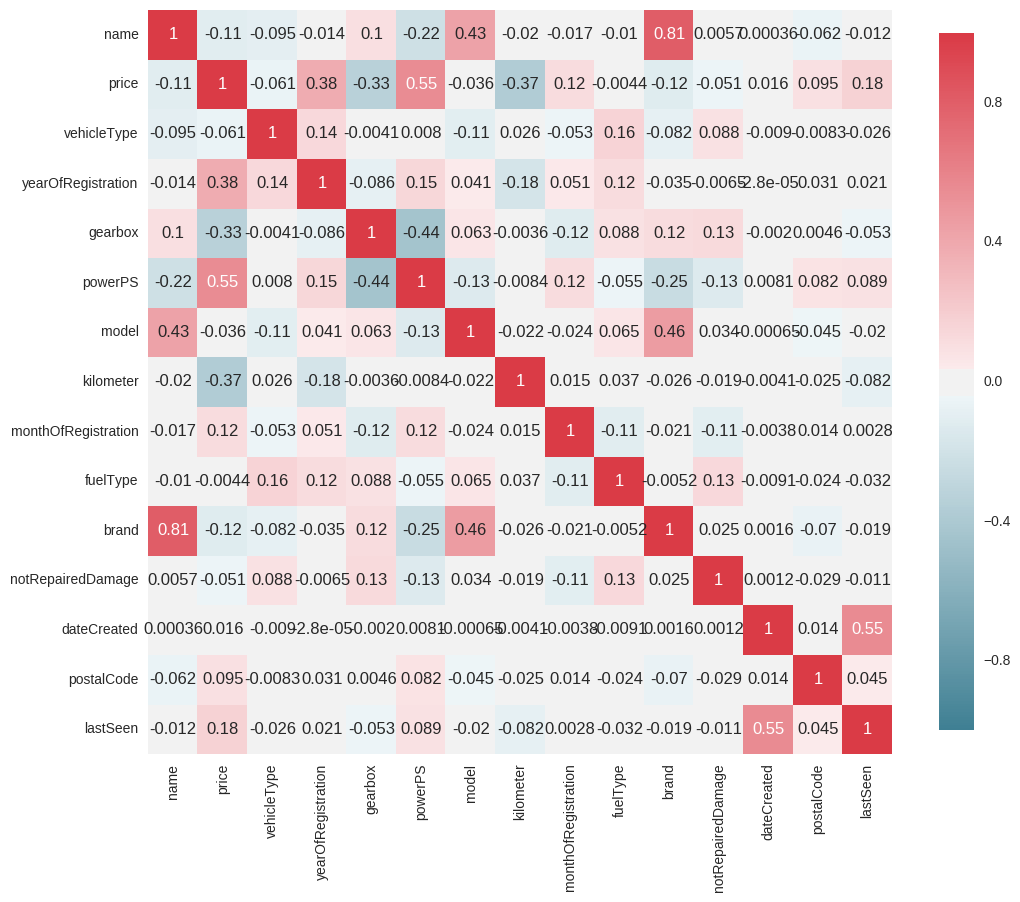

In [21]:
plot_correlation_map(dedups)
dedups.corr()

## Studying correlations between some features and sell price

I want to see how data is distributed and how it's related to the sell price. I start considering the numeric fields already present in the dataset, then I'll do other studies after having encoded the string fields.

In [ ]:
p = no_outliers
ax = sns.jointplot(x='powerPS', y='price',data=p[['powerPS','price']], alpha=0.1, size=8)
plt.title('Price distribution for car power')

plt.xlim(0, 501)
plt.ylim(0, 160000)


Price at varying yearOfRegistration

In [ ]:
p = no_outliers
#plt.scatter(p['yearOfRegistration'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='yearOfRegistration', 
                   y='price',
                   data=p[['yearOfRegistration','price']], 
                   alpha=0.1, size=8)

plt.title('Price distribution for year')

plt.ylim(0, 160000)



Price at varying kilometers

In [ ]:
p = no_outliers
#plt.scatter(p['kilometer'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='kilometer', y='price',data=p[['kilometer','price']], alpha=0.1, size=8)

plt.title('Price distribution for kilometers')
#plt.xlabel('Kilometers')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')
plt.ylim(0, 160000)
plt.xticks([5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,125000,150000], rotation='vertical')


### Features engineering

In [ ]:
p = no_outliers
p['namelen'] = [len(n) for n in p['name']]

print(p['namelen'].head())
#plt.scatter(p['namelen'][p['model']=='golf'], p['price'][p['model']=='golf'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='namelen', y='price',data=p[['namelen','price']][p['model']=='golf'], alpha=0.1, size=8)

p = p[p.namelen < 100] # removed the 22k chars name

plt.title('Price distribution for name length')
plt.ylim(0, 45000)
plt.xlim(0, 70)


Here I plotted the name length vs car price for all the vw golfs and it seems that more complete names bring to a bit higher sell price. Another explanation could be that a longer name includes more optionals and accessories and therefore the price is obviously higher.

Very short and very long names do not work well.

## Selecting only relevant columns

Here I select the columns that I think are useful for determining a car's price.


In [ ]:

# only relevant columns
rel_cols = no_outliers[['price'
                        ,'yearOfRegistration'
                        ,'gearbox'
                        ,'powerPS'
                        ,'model'
                        ,'kilometer'
                        ,'fuelType'
                        ,'vehicleType'
                        ,'monthOfRegistration'
                        ,'brand'
                        ,'notRepairedDamage'
                       , 'namelen']]
rel_cols.head()

## Encoding

This part encodes the string fields to numerical values, in order to study the rest of the columns and to make some regressions.

In [ ]:
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(rel_cols[l])
    #print(les[l].classes_)
    tr = les[l].transform(rel_cols[l]) 
    rel_cols.loc[:, l + '_feat'] = pd.Series(tr, index=rel_cols.index)

df_autos = rel_cols[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'
                        , 'namelen'] 
                    + [x+"_feat" for x in labels]]

df_autos['yearOfRegistration'] = df_autos['yearOfRegistration'].apply(lambda x: x-2000)

#print(df_autos['yearOfRegistration'])
autos = df_autos.values.astype(float)

Y = autos[:,0]
X = autos[:,1:]


### Studying the other correlations

In [ ]:
plt.title('Pearson Correlation')
sns.heatmap(df_autos.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap="PuBuGn", 
            linecolor='w', 
            annot=False)


In [ ]:
p = df_autos
#plt.scatter(p['powerPS'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='brand_feat', y='price',data=p[['brand_feat','price']], alpha=0.1, size=8)
plt.title('Price distribution for brands')
#plt.xlabel('Power in HP')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')

brands = zip(range(0, len(les['brand'].classes_)), les['brand'].classes_)

s = ''
for b in brands:
    s = s + ' ' + str(b)

print("brands: " + s)

plt.xlim(0, 41)
plt.ylim(0, 160000)

In [ ]:
p = df_autos[df_autos['brand_feat']==37]
#plt.scatter(p['powerPS'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='model_feat', y='price',data=p[['model_feat','price']], alpha=0.1, size=8)
plt.title('Price distribution for VW models')
#plt.xlabel('Power in HP')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')

model = zip(range(0, len(les['model'].classes_)), les['model'].classes_)

s = ''
for b in model:
    s = s + ' ' + str(b)

print("models: " + s)

#plt.xlim(0, 41)
plt.ylim(0, 160000)

In [ ]:
p = df_autos
f = plt.figure()

JG1 = sns.jointplot(x='fuelType_feat', y='price',data=p[['fuelType_feat','price']], alpha=0.1, size=4)
JG2 = sns.jointplot(x='vehicleType_feat', y='price',data=p[['vehicleType_feat','price']], alpha=0.1, size=4)
JG3 = sns.jointplot(x='gearbox_feat', y='price',data=p[['gearbox_feat','price']], alpha=0.1, size=4)
JG4 = sns.jointplot(x='notRepairedDamage_feat', y='price',data=p[['notRepairedDamage_feat','price']], alpha=0.1, size=4)

fuelTypes = zip(range(0, len(les['fuelType'].classes_)), les['fuelType'].classes_)
s = ''
for b in fuelTypes:
    s = s + ' ' + str(b)
print("Fuels: " + s)

vehicleTypes = zip(range(0, len(les['vehicleType'].classes_)), les['vehicleType'].classes_)
s = ''
for b in vehicleTypes:
    s = s + ' ' + str(b)
print("vehicleType: " + s)

gearboxes = zip(range(0, len(les['gearbox'].classes_)), les['gearbox'].classes_)
s = ''
for b in gearboxes:
    s = s + ' ' + str(b)
print("gearbox: " + s)

fuelTypes = zip(range(0, len(les['notRepairedDamage'].classes_)), les['notRepairedDamage'].classes_)
s = ''
for b in fuelTypes:
    s = s + ' ' + str(b)
print("notRepairedDamage: " + s)

#plt.xlim(0, 41)
plt.ylim(0, 160000)

## Correction

Transforming the right-skewed sale price column.


In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"1. Before":Y, "2. After":np.log1p(Y)})
prices.hist()

Y = np.log1p(Y)

# Playing with different models

Trying with some model from scikit learn: LinearRegression, LR with L2 regularization and others.

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split


def cv_rmse(model, x, y):
    r = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return r

r = range(2003, 2017)
km_year = 10000



## Linear Regression

In [ ]:
linear = linear_model.LinearRegression()

# Percent of the X array to use as training set. This implies that the rest will be test set
test_size = .2

#Split into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
linear.fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
score = linear.score(X_test, y_test)
print('Variance score: %.2f' % score)

print("rmse on validation set", cv_rmse(linear, X_test, y_test).mean())

# Last version results:
# Variance score: 0.68
# rmse on validation set 0.639555427197


#### Predicting samples

In [ ]:

def calc_values(model, year, brand, car_model, vehicle, gearbox, fuel, powerPS, km, not_repaired_damage):
    sample = [year
          , powerPS
          , km
          , 1 # month
          , 35 # namelen
          , les['gearbox'].transform([gearbox])
          , les['notRepairedDamage'].transform([not_repaired_damage])
          , les['model'].transform([car_model])
          , les['brand'].transform([brand])
          , les['fuelType'].transform([fuel])
          , les['vehicleType'].transform([vehicle])]
    s_predict = np.expm1(model.predict([sample]))
    return s_predict

# [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
vw1 = calc_values(linear, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(linear, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(linear, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(linear, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_linear  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_linear2  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_linear3  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_linear, label='linear')
plt.plot(r, values_linear2, label='linear 20000km_x_y')
plt.plot(r, values_linear3, label='linear 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## L1 regularized LR


In [ ]:

alphas = [0.005,0.05, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10, 20, 25, 30, 50]
cv_lasso = [cv_rmse(Lasso(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_lasso = Lasso(alpha = cv_lasso.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_lasso.score(X_test, y_test))

coef = pd.Series(model_lasso.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_lasso.predict(X_test))**2)))
print("rmse on validation set", cv_rmse(model_lasso, X_test, y_test).mean())

# Last version results:
# 0.707839916347
# rmse on validation set 0.708803418524


#### Predicting samples

In [ ]:
vw1 = calc_values(model_lasso, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_lasso, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_lasso, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_lasso, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_lasso  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_lasso2  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_lasso3  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_lasso, label='lasso')
plt.plot(r, values_lasso2, label='lasso 20000km_x_y')
plt.plot(r, values_lasso3, label='lasso 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## L2 regularized LR

In [ ]:

alphas = [-10, -5, -2, -1, 0, 0.005,0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 25, 30, 50]
cv_ridge = [cv_rmse(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_ridge = Ridge(alpha = cv_ridge.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_ridge.score(X_test, y_test))

coef = pd.Series(model_ridge.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_ridge.predict(X_test))**2)))
print("rmse on validation set", cv_rmse(model_ridge, X_test, y_test).mean())

# Last version results:
# 0.639334838313
# rmse on validation set 0.639555431574


#### Predicting samples

In [ ]:
vw1 = calc_values(model_ridge, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_ridge, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_ridge, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_ridge, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_ridge  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_ridge2  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_ridge3  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_ridge, label='ridge')
plt.plot(r, values_ridge2, label='ridge 20000km_x_y')
plt.plot(r, values_ridge3, label='ridge 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Random forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 50)
forest.fit(X_train, y_train)

In [ ]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % forest.score(X_test, y_test))

print(np.sqrt(np.mean((y_test - forest.predict(X_test))**2)))
print("rmse on validation set", cv_rmse(forest, X_test, y_test).mean())

# Last version results
# Variance score: 0.88
# 0.391895988852
# rmse on validation set 0.426248010639


#### Predicting samples

In [ ]:
vw1 = calc_values(forest, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(forest, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(forest, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(forest, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

#values_forest = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
#values_forest2 = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year* 2 * (2017-y), 'nein') for y in r]
#values_forest3 = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year* 3 * (2017-y), 'nein') for y in r]

values_forest  = [calc_values(forest, y, 'audi', 'a3', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_forest4 = [calc_values(forest, y, 'volkswagen', 'golf', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_forest5 = [calc_values(forest, y, 'seat', 'ibiza', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_forest6 = [calc_values(forest, y, 'dacia', 'logan', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]


plt.plot(r, values_forest, label='audi')
plt.plot(r, values_forest4, label='vw')
plt.plot(r, values_forest5, label='seat')
plt.plot(r, values_forest6, label='dacia')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Testing XGBoost

In [ ]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

clf = XGBRegressor()
clf.fit(X_train, y_train)


In [ ]:
xgb.plot_importance(clf)

#f0 = year
#f1 = powerPS
#f2 = km
#f3 = month
#f4 = namelen
#f5 = gearbox
#f6 = notRepairedDamage
#f7 = model
#f8 = brand
#f9 = fuelType
#f10 = vehicleType

# make predictions for test data
y_pred = clf.predict(X_test)
print(np.sqrt(np.mean((y_test - y_pred)**2)))

# Last version results
# 0.433305159267


#### Predicting samples

In [ ]:
values_clf  = [calc_values(clf, y, 'audi', 'a3', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_clf2 = [calc_values(clf, y, 'audi', 'a3', 'coupe', 'manuell', 'diesel', 105, km_year * (2017-y), 'nein') for y in r]
values_clf3 = [calc_values(clf, y, 'audi', 'a3', 'coupe', 'manuell', 'diesel', 200, km_year * (2017-y), 'nein') for y in r]
values_clf  = [calc_values(clf, y, 'audi', 'a3', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_clf4 = [calc_values(clf, y, 'volkswagen', 'golf', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_clf5 = [calc_values(clf, y, 'seat', 'ibiza', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_clf6 = [calc_values(clf, y, 'dacia', 'logan', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
#plt.plot(r, values_clf2, label='audi 105cv')
#plt.plot(r, values_clf3, label='audi 200cv')
plt.plot(r, values_clf , label='audi 140cv')
plt.plot(r, values_clf4, label='golf ')
plt.plot(r, values_clf5, label='ibiza ')
plt.plot(r, values_clf6, label='dacia ')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Conclusions

I've tried to play with as much stuff as I could with this dataset in order to understand the very basic topics about:

* data interpretation and selection
* feature selection and labeling
* data visualization
* very rough ML algorithms application

There's very much to improve both in how I managed all these steps and in the different outcomes of the predictions on the sell price. I'll experiment a bit more in the next few days, then I'll move on another dataset to learn more.
